<a href="https://colab.research.google.com/github/wkotala/DNN-HW1/blob/main/DNN-homework-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Multitask Learning for Geometric Shape Classification and Counting**

# Setup

In [40]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip -o data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-20 22:09:41--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-20 22:09:42--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.01s   

2025-11-20 22:09:42 (453 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



In [41]:
# TODO: install all required dependencies

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import sys
import plotly.graph_objects as go

from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
from typing import Callable, Type
from plotly.subplots import make_subplots
from IPython.display import display
from enum import Enum

if "google.colab" in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()

torch.manual_seed(1)

# Exploratory Data Analysis

In [43]:
data_dir = Path('data')
labels_df = pd.read_csv(data_dir / 'labels.csv')
labels_df

,name,squares,circles,up,right,down,left
0,img_00000.png,0,0,4,0,6,0
1,img_00001.png,0,0,0,5,0,5
2,img_00002.png,0,0,8,0,2,0
3,img_00003.png,0,7,0,0,0,3
4,img_00004.png,0,0,3,0,0,7
...,...,...,...,...,...,...,...
9995,img_09995.png,3,0,7,0,0,0
9996,img_09996.png,8,0,2,0,0,0
9997,img_09997.png,8,0,0,0,0,2
9998,img_09998.png,6,0,0,4,0,0


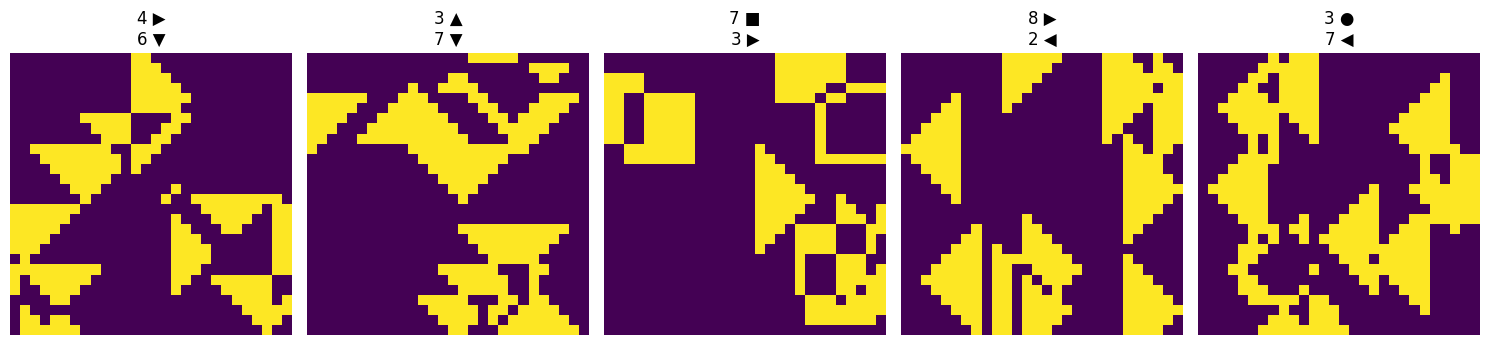

In [44]:
sample_df = labels_df[10:15]
shapes = {
    'squares': '\u25A0',
    'circles': '\u25CF',
    'up': '\u25B2',
    'right': '\u25B6',
    'down': '\u25BC',
    'left': '\u25C0',
}

fig, axes = plt.subplots(1, len(sample_df), figsize=(15, 4))

for ax, row in zip(axes, sample_df.itertuples()):
    # Plot the image.
    img_path = data_dir / row.name
    img = Image.open(img_path).convert('L')
    ax.imshow(img)

    # Display info about shapes in the image.
    title_parts = [
        f'{count} {shape_symbol}'
        for shape_name, shape_symbol in shapes.items()
        if (count := getattr(row, shape_name)) > 0
    ]
    ax.set_title('\n'.join(title_parts))
    ax.axis('off')

plt.tight_layout()
plt.show()

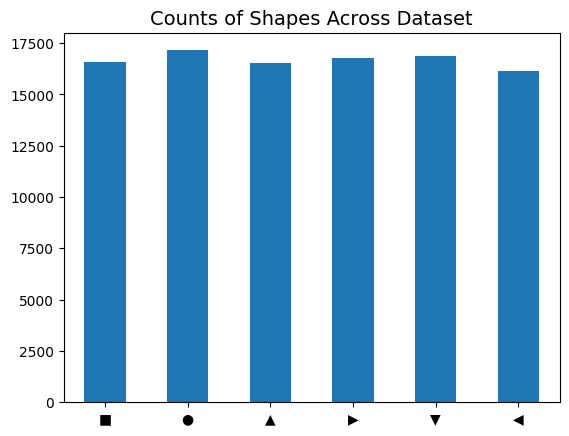

In [45]:
plt.title('Counts of Shapes Across Dataset', fontsize=14)
labels_df.drop('name', axis=1).sum().rename(shapes).plot.bar(rot=0)
plt.show()

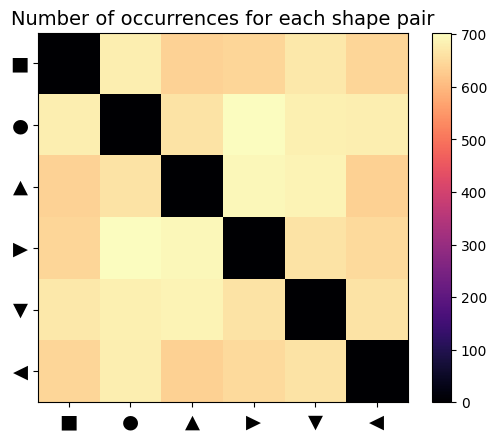

In [46]:
occurrence = (labels_df.drop('name', axis=1) > 0).astype(int)
co_occurrence = occurrence.T @ occurrence
for i in range(len(co_occurrence)):
    co_occurrence.iat[i,i] = 0

# Draw a heatmap.
plt.title('Number of occurrences for each shape pair', fontsize=14)
plt.imshow(co_occurrence, cmap='magma')
plt.colorbar()

# Label the axes.
tick_positions = np.arange(len(co_occurrence.columns))
tick_labels = [shapes[name] for name in co_occurrence.columns]
plt.xticks(tick_positions, tick_labels, fontsize=14)
plt.yticks(tick_positions, tick_labels, fontsize=14, va='center')

plt.show()

In [47]:
# TODO: check how many of each classes are there

# Data pipeline

## Augmentations

In [48]:
class RandomTransformator:
    """
    Assumes shapes are in order: squares, circles, up, right, down, left.
    """

    def __call__(self, img: Tensor, counts: Tensor) -> tuple[Tensor, Tensor]:
        """ Performs random transformations. """
        img, counts = self.horizontal_flip(img, counts, p=0.5)
        img, counts = self.vertical_flip(img, counts, p=0.5)
        img, counts = self.rotation(img, counts)
        return img, counts

    def horizontal_flip(self, img: Tensor, counts: Tensor, p: float = 1) -> tuple[Tensor, Tensor]:
        """ Flips image horizontally with probability = p """
        if torch.rand(1) < p:
            img = img.flip(2)
            counts[3], counts[5] = counts[5].item(), counts[3].item()

        return img, counts

    def vertical_flip(self, img: Tensor, counts: Tensor, p: float = 1) -> tuple[Tensor, Tensor]:
        """ Flips image vertically with probability = p """
        if torch.rand(1) < p:
            img = img.flip(1)
            counts[2], counts[4] = counts[4].item(), counts[2].item()

        return img, counts

    def rotation(self, img: Tensor, counts: Tensor) -> tuple[Tensor, Tensor]:
        """ Rotates image by random angle from: 0, pi/2, pi, -pi/2 """
        k = torch.randint(-1, 3, size=(1,)).item()
        img = img.rot90(k=k, dims=(1,2))

        triangles_shifted = torch.roll(counts[2:], -k)
        counts[2:] = triangles_shifted

        return img, counts

## Dataset

In [49]:
class GSNDataset(Dataset):
    """
    Custom PyTorch Dataset for the Geometric Shape Numbers (GSN) dataset.

    GSNDataset handles two tasks:
    1. Classification: Identifying which of the 135 possible shape-pair
       and count-split configurations is present in the image.
    2. Regression: Predicting the count of 6 different shape types.
    """

    def __init__(self, data_dir: Path, train: bool, train_val_split: float = 0.9, transform: Callable | None = None):
        """
        Input:
        - data_dir: Path to the directory containing 'labels.csv' and all the images.
        - train: A boolean indicating whether to create train or validation dataset.
        - train_val_split: Fraction specifying what percentage of data is train data; the rest is validation data.
        - transform: Optional transform to be applied on a sample.
                     transform should implement __call__(image, counts) -> (transformed_image, transformed_counts),
                     where images is a tensor of shape (C=1, H=28, W=28),
                     and counts is a tensor of shape (6,), with count of shapes in the same order as in self.shape_names()
        """
        self.data_dir = data_dir
        self.transform = transform

        all_labels_df = pd.read_csv(data_dir / 'labels.csv')
        train_len = round(len(all_labels_df) * train_val_split)

        if train:
            self.labels_df = all_labels_df[:train_len].reset_index(drop=True)
        else:
            self.labels_df = all_labels_df[train_len:].reset_index(drop=True)

        self.shape_columns = list(self.labels_df.drop('name', axis=1).columns)

        self._pair_to_id = dict()
        pair_id = 0
        for i in range(len(self.shape_columns)):
            for j in range(i + 1, len(self.shape_columns)):
                self._pair_to_id[(i, j)] = pair_id
                pair_id += 1

    def shape_names(self) -> list[str]:
        """
        Returns list of shape names used in dataset.
        Order of the shapes in this list dictates:
        - Order of count labels for regression model.
        - Class labels for classification model:
            - classes 0...8 contain shapes list[0], list[1]
            - classes 9...17 contain shapes list[0], list[2],
            ...
            - classes 36...44 contain shapes list[0], list[5],
            - classes 45...53 contain shapes list[1], list[2],
            ...
            - classes 126...134 contain shapes list[4], list[5].
        """
        return self.shape_columns

    def _calculate_class_from_shapes_counts(self, counts: Tensor) -> Tensor:
        """
        Translates shape configurations into unique class labels.

        Input: counts of each shape in an image as tensor of shape (6,)
        Output: class label, i.e. integer in [0, 134], as Tensor
        """
        nonzero_indices = torch.nonzero(counts, as_tuple=True)[0]
        assert len(nonzero_indices) == 2
        assert counts[nonzero_indices].sum() == 10

        pair = tuple(nonzero_indices.tolist())
        assert pair in self._pair_to_id
        return self._pair_to_id[pair] * 9 + counts[pair[0]] - 1

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx: int) -> tuple[Tensor, Tensor, Tensor]:
        """
        Output:
        - image as tensor of shape (C=1, H=28, W=28)
        - class label as tensor of shape (1,)
        - true counts as tensor of shape (6,)
        """
        row = self.labels_df.iloc[idx]
        img_path = self.data_dir / row['name']
        img = Image.open(img_path).convert('L')
        img_tensor = transforms.functional.to_tensor(img)

        counts = torch.tensor(row[self.shape_columns].astype(np.float32).to_numpy(), dtype=torch.float32)

        if self.transform:
            img_tensor, counts = self.transform(img_tensor, counts)

        class_label = self._calculate_class_from_shapes_counts(counts).to(torch.long)

        return img_tensor, class_label, counts

# TODO: check if transformations dont compute gradients

# TODO: change shape_columns in __init__ if doesn't match expectations

# Model architecture

In [50]:
class MultitaskModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(), # (B, 8, H, W)
            nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(), # (B, 16, H, W)
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(), # (B, 32, H, W)
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(), # (B, 64, H, W)
            nn.Flatten(start_dim=1), # (B, 64 * H * W)
            nn.Linear(64 * 28 * 28, 256), nn.ReLU() # (B, 256)
        )

        # TODO: experiment with the heads

        self.head_cls = nn.Sequential(
            nn.Linear(256, 256), # (B, 256)
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 135), # (B, 135)
            nn.LogSoftmax(dim=1)
        )

        self.head_cnt = nn.Sequential(
            nn.Linear(256, 128), # (B, 128)
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 6), # (B, 6)
        )

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """
        Input shape: (B, 1, H, W).
        Output:
        - classification log-probabilities (B, 135)
        - regression counts (B, 6)
        """
        features = self.backbone(x)
        log_probs = self.head_cls(features)
        counts = self.head_cnt(features)
        return log_probs, counts

# Training & Evaluation

## Setup

In [51]:
@dataclass
class TrainingSettings:
    device: torch.device

    learning_rate: float = 1e-3
    max_epochs: int = 100
    train_batch_size: int = 64

    cls_loss_fn: Callable = F.nll_loss        # classification loss function
    lambda_cls: float = 1.0                   # weight of classification loss function
    cnt_loss_fn: Callable = F.smooth_l1_loss  # regression loss function
    lambda_cnt: float = 1.0                   # weight of regression loss function

    early_stop_patience: int = 10

    optimizer: Type[torch.optim.Optimizer] = torch.optim.Adam

## Evaluation

In [52]:
class ClassificationMetricsCalculator:
    """
    Calculates classification metrics.
    Each method follows the convention:
    Input:
    - predicted classes as tensor of shape (B,)
    - actual classes as tensor of shape (B,)
    Output:
    - calculated metric as float
    """

    def __init__(self, eps: float = 1e-8):
        self.n_classes = 135
        self.eps = eps

    def top_1_accuracy(self, pred_class: Tensor, actual_class: Tensor) -> float:
        return (pred_class == actual_class).to(torch.float32).mean().item()

    def macro_f1(self, pred_class: Tensor, actual_class: Tensor) -> float:
        tp = torch.zeros(self.n_classes, device=pred_class.device)
        fp = torch.zeros(self.n_classes, device=pred_class.device)
        fn = torch.zeros(self.n_classes, device=pred_class.device)

        for i in range(self.n_classes):
            tp[i] = ((pred_class == i) & (actual_class == i)).sum()
            fp[i] = ((pred_class == i) & (actual_class != i)).sum()
            fn[i] = ((pred_class != i) & (actual_class == i)).sum()

        f1 = 2 * tp / (2 * tp + fp + fn + self.eps)

        classes_present = (tp + fn) > 0
        f1 = f1[classes_present]
        return f1.mean().item()


    def per_pair_accuracy(self, pred_class: Tensor, actual_class: Tensor) -> float:
        per_pair_accuracy_sum = 0.0
        num_pairs_present = 0

        for i in range(0, self.n_classes, 9):
            mask = (i <= actual_class) & (actual_class <= i + 8)
            if mask.any():
                per_pair_accuracy_sum += self.top_1_accuracy(pred_class[mask], actual_class[mask])
                num_pairs_present += 1

        per_pair_accurace_average = per_pair_accuracy_sum / num_pairs_present if num_pairs_present > 0 else float('nan')
        return per_pair_accurace_average

class RegressionMetricsCalculator:
    """
    Calculates regression metrics.
    Each method follows the convention:
    Input:
    - predicted counts as tensor of shape (B, 6)
    - actual counts as tensor of shape (B, 6)
    Output:
    - calculated per-class metric as tensor of shape (6,)
    - calculated overall metric as tensor of shape (6,)
    """

    def mae_per_class(self, pred_counts: Tensor, actual_counts: Tensor) -> Tensor:
        absolute_error = torch.abs(pred_counts - actual_counts)
        return absolute_error.mean(dim=0)

    def mae(self, pred_counts: Tensor, actual_counts: Tensor) -> float:
        absolute_error = torch.abs(pred_counts - actual_counts)
        return absolute_error.mean().item()

    def rmse_per_class(self, pred_counts: Tensor, actual_counts: Tensor) -> Tensor:
        squared_error = torch.square(pred_counts - actual_counts)
        return torch.sqrt(squared_error.mean(dim=0))

    def rmse(self, pred_counts: Tensor, actual_counts: Tensor) -> float:
        squared_error = torch.square(pred_counts - actual_counts)
        return torch.sqrt(squared_error.mean()).item()


class MetricsCalculator:
    def __init__(self):
        self.cls = ClassificationMetricsCalculator()
        self.cnt = RegressionMetricsCalculator()

# TODO: revisit this implementation


# TODO: pretty presentation of those metrics

# TODO: rmse and mae overall - what do they mean???

# TODO: change all "" to '' everywhere in notebook

In [53]:
class TraceName(str, Enum):
    TRAIN_CLS = 'train cls loss'
    TRAIN_CNT = 'train cnt loss'
    TRAIN_LOSS = 'train loss'

    VAL_CLS = 'val cls loss'
    VAL_CNT = 'val cnt los'
    VAL_LOSS = 'val loss'
    VAL_ACC = 'val accuracy'
    VAL_RMSE = 'val RMSE'

class TrainingVisualizer:
    def __init__(self):
        """
            Defines layout of the training dashboard and displays empty plots.
        """

        # Data that will be visualized.
        self.data = {trace_name: [] for trace_name in TraceName}

        # Layout.
        plots = make_subplots(
            rows=2, cols=3,
            specs=[[{"colspan": 3}, None, None],
                   [{}, {}, {}]],
            subplot_titles=("Training Losses", "Validation Losses", "Validation Accuracy", "Validation RMSE"),
        ).update_layout(
            template='plotly_dark',
            height=800,
            title_text="Training Dashboard"
        )

        plots.update_xaxes(title_text='Epoch')
        plots.update_yaxes(title_text="Average Loss Value", col=1)
        plots.update_yaxes(title_text="Accuracy %", row=2, col=2)
        plots.update_yaxes(title_text="RMSE Value", row=2, col=3)

        # Traces.
        train_losses_pos = {'row': 1, 'col': 1}
        val_losses_pos = {'row': 2, 'col': 1}

        traces_config = [ # list  of tuples (name, position)
            (TraceName.TRAIN_CLS, train_losses_pos),
            (TraceName.TRAIN_CNT, train_losses_pos),
            (TraceName.TRAIN_LOSS, train_losses_pos),
            (TraceName.VAL_CLS, val_losses_pos),
            (TraceName.VAL_CNT, val_losses_pos),
            (TraceName.VAL_LOSS, val_losses_pos),
            (TraceName.VAL_ACC, {'row': 2, 'col': 2}),
            (TraceName.VAL_RMSE, {'row': 2, 'col': 3})
        ]

        for name, pos in traces_config:
            plots.add_trace(go.Scatter(name=name), **pos)

        # Display the plots as widget that will be updated each epoch.
        self.plots = go.FigureWidget(plots)
        self.traces = {trace.name: trace for trace in self.plots.data}
        display(self.plots)

    def _update_plot(self, updates: dict[TraceName, float], curr_len: int):
        with self.plots.batch_update():
            new_len = curr_len + 1
            x_axis = list(range(1, new_len + 1))

            for trace_name, value in updates.items():
                self.data[trace_name].append(value)
                self.traces[trace_name].x = x_axis
                self.traces[trace_name].y = self.data[trace_name]

    def plot_train(self, cls_loss: float, cnt_loss: float, loss: float):
        """
        Updates the dashboard with data from train phase.
        """
        self._update_plot({
            TraceName.TRAIN_CLS: cls_loss,
            TraceName.TRAIN_CNT: cnt_loss,
            TraceName.TRAIN_LOSS: loss

        }, len(self.data[TraceName.TRAIN_LOSS]))

    def plot_val(self, cls_loss: float, cnt_loss: float, loss: float, accuracy: float, rmse: float):
        """
        Updates the dashboard with data from validation phase.
        """
        self._update_plot({
            TraceName.VAL_CLS: cls_loss,
            TraceName.VAL_CNT: cnt_loss,
            TraceName.VAL_LOSS: loss,
            TraceName.VAL_ACC: accuracy * 100, # convert to %
            TraceName.VAL_RMSE: rmse

        }, len(self.data[TraceName.VAL_LOSS]))

In [54]:
def evaluate(model: nn.Module, loader: DataLoader, settings: TrainingSettings, calc: MetricsCalculator, visualizer: TrainingVisualizer) -> None:
    model.eval()

    with torch.no_grad():
        for images, class_labels, counts in loader:
            images = images.to(settings.device)
            class_labels = class_labels.to(settings.device)
            counts = counts.to(settings.device)

            log_probs, pred_counts = model(images)

            cls_loss = settings.cls_loss_fn(log_probs, class_labels)
            cnt_loss = settings.cnt_loss_fn(pred_counts, counts)
            loss = settings.lambda_cls * cls_loss + settings.lambda_cnt * cnt_loss

            pred_class = torch.argmax(log_probs, dim=1)

        accuracy = calc.cls.top_1_accuracy(pred_class, class_labels)
        rmse = calc.cnt.rmse(pred_counts, counts)
        visualizer.plot_val(cls_loss.item(), cnt_loss.item(), loss.item(), accuracy, rmse)

    return loss.item() # TODO: make it not assume batch size = len(dataset)

## Training

In [55]:
def train_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer, settings: TrainingSettings, visualizer: TrainingVisualizer) -> None:
    model.train()
    total_correct = 0
    total_cls_loss = 0.0
    total_cnt_loss = 0.0

    for images, class_labels, counts in loader:
        images = images.to(settings.device)
        class_labels = class_labels.to(settings.device)
        counts = counts.to(settings.device)

        optimizer.zero_grad()

        log_probs, pred_counts = model(images)

        cls_loss = settings.cls_loss_fn(log_probs, class_labels)
        cnt_loss = settings.cnt_loss_fn(pred_counts, counts)
        loss = settings.lambda_cls * cls_loss + settings.lambda_cnt * cnt_loss

        loss.backward()
        optimizer.step()

        # TODO: this should be visualizer's task probably
        with torch.no_grad():
            pred_class = torch.argmax(log_probs, dim=1)
            total_correct += (pred_class == class_labels).sum().item()
            total_cls_loss += cls_loss.item()
            total_cnt_loss += cnt_loss.item()


    avg_cls_loss = total_cls_loss / len(loader)
    avg_cnt_loss = total_cnt_loss / len(loader)
    avg_total_loss = settings.lambda_cls * avg_cls_loss + settings.lambda_cnt * avg_cnt_loss
    print(f'Classification loss: {avg_cls_loss}')
    print(f'Regression loss: {avg_cnt_loss}')
    print(f'Total loss: {avg_total_loss}')
    print(f'Accuracy: {total_correct / len(loader.dataset) * 100  :.2f}%')

In [56]:
class EarlyStopper:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

# TODO: TrainingReporter

def train_loop(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, settings: TrainingSettings, calc: MetricsCalculator, visualizer: TrainingVisualizer) -> None:
    optimizer = settings.optimizer(model.parameters(), lr=settings.learning_rate)
    early_stopper = EarlyStopper(patience=settings.early_stop_patience)

    for epoch in range(settings.max_epochs):
        print(f'Epoch {epoch + 1}')
        train_epoch(model, train_loader, optimizer, settings, visualizer)
        val_loss = evaluate(model, val_loader, settings, calc, visualizer)

        if early_stopper(val_loss):
            print(f"Early stopping triggered!")
            break

        print()

# Experiments

In [57]:
data_dir = Path('data')
transformator = RandomTransformator()
train_dataset = GSNDataset(data_dir, train=True, transform=transformator)
val_dataset = GSNDataset(data_dir, train=False, transform=None)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
settings = TrainingSettings(device=device)


kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {}
train_loader = DataLoader(train_dataset, batch_size=settings.train_batch_size, shuffle=True, **kwargs)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), **kwargs)

model = MultitaskModel().to(device)

calc = MetricsCalculator()
visualizer = TrainingVisualizer()

# TODO: actually make the experiments

FigureWidget({
    'data': [{'name': <TraceName.TRAIN_CLS: 'train cls loss'>,
              'type': 'scatter',
              'uid': '7b365446-0766-44c5-b327-5142cfb73226',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.TRAIN_CNT: 'train cnt loss'>,
              'type': 'scatter',
              'uid': 'ed30b2f0-f4b7-4ea9-942e-eb7905afdf56',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.TRAIN_LOSS: 'train loss'>,
              'type': 'scatter',
              'uid': '09b6067f-c8f3-4a2c-aeb8-8935e8bb71a8',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.VAL_CLS: 'val cls loss'>,
              'type': 'scatter',
              'uid': 'f597e732-b453-4866-b3cb-9a4bc0373600',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'name': <TraceName.VAL_CNT: 'val cnt los'>,
              'type': 'scatter',
              'uid': '352476b0-73ba-4c53-86

In [58]:
train_loop(model, train_loader, val_loader, settings, calc, visualizer)

Epoch 1
Classification loss: 4.737409588292981
Regression loss: 1.426794315060825
Total loss: 6.1642039033538065
Accuracy: 1.10%
Classification loss: 4.67
Regression loss:     1.42
Total loss:          6.09
Accuracy:            0.90%

Epoch 2
Classification loss: 4.683309193198562
Regression loss: 1.4210910940846653
Total loss: 6.1044002872832275
Accuracy: 0.97%
Classification loss: 4.66
Regression loss:     1.42
Total loss:          6.08
Accuracy:            1.10%

Epoch 3
Classification loss: 4.381814246482038
Regression loss: 1.342585786014584
Total loss: 5.7244000324966215
Accuracy: 2.09%
Classification loss: 3.86
Regression loss:     1.21
Total loss:          5.08
Accuracy:            3.60%

Epoch 4
Classification loss: 3.696882542143477
Regression loss: 1.1281094580677384
Total loss: 4.824992000211215
Accuracy: 5.68%
Classification loss: 3.20
Regression loss:     0.93
Total loss:          4.13
Accuracy:            10.30%

Epoch 5
Classification loss: 3.0444788696072624
Regression